# Environment 

In [1]:
!pip install -r ../requirements.txt

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import s3fs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


Temporary (torchFastText in active development)

In [3]:
sys.path.append("../")
from torchFastText import torchFastText
from torchFastText.preprocess import clean_text_feature
from torchFastText.datasets import NGramTokenizer

%load_ext autoreload
%autoreload 2

In [4]:
# !pip install torchFastText

Some useful functions that will help us format our dataset

In [5]:
sys.path.append("notebooks/")
from utils import categorize_surface, clean_and_tokenize_df, stratified_split_rare_labels, add_libelles

# Load and preprocess data

In [6]:
fs = s3fs.S3FileSystem(
    client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"},
    anon=True,
)
df = (
    pq.ParquetDataset(
        "projet-ape/extractions/20241027_sirene4.parquet",
        filesystem=fs,
    )
    .read_pandas()
    .to_pandas()
).sample(frac=0.001).fillna(np.nan)

2025-02-26 10:34:04 - botocore.httpchecksum - Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
2025-02-26 10:34:04 - botocore.httpchecksum - Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
2025-02-26 10:34:04 - botocore.httpchecksum - Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
2025-02-26 10:34:04 - botocore.httpchecksum - Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
2025-02-26 10:34:05 - botocore.httpchecksum - Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


In [7]:
with fs.open("projet-ape/data/naf2008.csv") as file:
    naf2008 = pd.read_csv(file, sep=";")
naf2008

2025-02-26 10:34:09 - botocore.httpchecksum - Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


,code,libelle
0,0111Z,"Culture de céréales (à l'exception du riz), de..."
1,0112Z,Culture du riz
2,0113Z,"Culture de légumes, de melons, de racines et d..."
3,0114Z,Culture de la canne à sucre
4,0115Z,Culture du tabac
...,...,...
727,9609Z,Autres services personnels n.c.a.
728,9700Z,Activités des ménages en tant qu'employeurs de...
729,9810Z,Activités indifférenciées des ménages en tant ...
730,9820Z,Activités indifférenciées des ménages en tant ...


In [8]:
categorical_features = ["evenement_type", "cj",  "activ_nat_et", "liasse_type", "activ_surf_et", "activ_perm_et"]
text_feature = "libelle"
y = "apet_finale"
textual_features = None

df = add_libelles(df, naf2008, y, text_feature, textual_features, categorical_features)

	*** 732 codes have been added in the database...



## Preprocess text and target

We make available our processing function clean_text_feature for the text.

In [9]:
df["libelle_processed"] = clean_text_feature(df["libelle"])

In [10]:
encoder = LabelEncoder()
df["apet_finale"] = encoder.fit_transform(df["apet_finale"])

Put the columns in the right format:
 - First column contains the processed text (str)
 - Next ones contain the "encoded" categorical (discrete) variables in int format

X and y are arrays.

In [11]:
df, _ = clean_and_tokenize_df(df, text_feature="libelle_processed")
X = df[["libelle_processed", "EVT", "CJ", "NAT", "TYP", "CRT", "SRF"]].values
y = df["apet_finale"].values


/home/onyxia/work/torch-fastText/notebooks/utils.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("nan", inplace=True)


In [12]:
print("Features for the 3 first obs:\n")
print(X[:3])
print("\n")
print("NAF codes (labels) for the 3 first obs:\n")
print(y[:3])

Features for the 3 first obs:

[['vent lign' 2 26 7 1 1 0]
 ['nettoyag murs, murets, bat' 6 26 7 7 1 0]
 ["creation vent bijoux fantais fait main soin (colliers, bracelets, boucl d'oreil etc)."
  2 26 0 7 1 0]]


NAF codes (labels) for the 3 first obs:

[480 628 293]


We split the data into train and test sets. We especially take care that:  
- classes with only one instance appear in the train set (instead of the test set)
- all classes are represented in the train set

The `stratified_split_rare_labels` function from the `preprocess` subpackage is used to carefully split the data.

In [13]:
X_train, X_test, y_train, y_test = stratified_split_rare_labels(X, y)
assert set(range(len(naf2008["code"]))) == set(np.unique(y_train))

In [14]:
X_train.shape

(2793, 7)

# Build the torch-fastText model (without training it)

We first initialize the model (without building it).

In [15]:
# Parameters for model building
NUM_TOKENS= int(1e5) # Number of rows in the embedding matrix = size of the embedded vocabulary
EMBED_DIM = 50 # Dimension of the embedding = number of columns in the embedding matrix
SPARSE = False # Whether to use sparse Embedding layer for fast computation (see PyTorch documentation)
CAT_EMBED_DIM = 10 # Dimension of the embedding for categorical features

# Parameters for tokenizer
MIN_COUNT = 1 # Minimum number of occurrences of a word in the corpus to be included in the vocabulary
MIN_N = 3 # Minimum length of char n-grams
MAX_N = 6 # Maximum length of char n-grams
LEN_WORD_NGRAMS = 3 # Length of word n-grams

# Parameters for training - not useful immediately
LR = 4e-3 # Learning rate
NUM_EPOCHS = 1
BATCH_SIZE = 256
PATIENCE = 3


In [16]:
model = torchFastText(
    num_tokens=NUM_TOKENS,
    embedding_dim=EMBED_DIM,
    categorical_embedding_dims=CAT_EMBED_DIM,
    min_count=MIN_COUNT,
    min_n=MIN_N,
    max_n=MAX_N,
    len_word_ngrams=LEN_WORD_NGRAMS,
    sparse = SPARSE
)

We can save these parameters to a JSON file. Initialization can also be done providing a JSON file path.

In [17]:
model.to_json('torchFastText_config.json')

In [18]:
model = torchFastText.from_json('torchFastText_config.json')

We build the model using the training data. 
We have now access to the tokenizer, the PyTorch model as well as a PyTorch Lightning module ready to be trained.
Note that Lightning is high-level framework for PyTorch that simplifies the process of training, validating, and deploying machine learning models.

In [19]:
model.build(X_train, y_train, lightning=True, lr = LR)

2025-02-26 10:34:11 - torchFastText.model.pytorch_model - num_rows is different from the number of tokens in the tokenizer. Using provided num_rows.
2025-02-26 10:34:11 - torchFastText.torchFastText - No scheduler parameters provided. Using default parameters (suited for ReduceLROnPlateau).


In [20]:
print("==== Model\n")
print(model.pytorch_model)
print("\n==== Tokenizer\n")
print(model.tokenizer)
print("\n==== Lightning Module\n")
print(model.lightning_module)

==== Model

FastTextModel(
  (embeddings): EmbeddingBag(103957, 50, mode='mean')
  (emb_0): Embedding(24, 10)
  (emb_1): Embedding(27, 10)
  (emb_2): Embedding(9, 10)
  (emb_3): Embedding(13, 10)
  (emb_4): Embedding(3, 10)
  (emb_5): Embedding(4, 10)
  (fc): Linear(in_features=60, out_features=732, bias=True)
)

==== Tokenizer

<NGramTokenizer(min_n=3, max_n=6, num_tokens=100000, word_ngrams=3, nwords=3956)>

==== Lightning Module

FastTextModule(
  (model): FastTextModel(
    (embeddings): EmbeddingBag(103957, 50, mode='mean')
    (emb_0): Embedding(24, 10)
    (emb_1): Embedding(27, 10)
    (emb_2): Embedding(9, 10)
    (emb_3): Embedding(13, 10)
    (emb_4): Embedding(3, 10)
    (emb_5): Embedding(4, 10)
    (fc): Linear(in_features=60, out_features=732, bias=True)
  )
  (loss): CrossEntropyLoss()
  (accuracy_fn): MulticlassAccuracy()
)


This step is useful to initialize the full torchFastText model without training it, if needed for some reason. 

But if it is not necessary, we could have directly launched the training (building is then handled automatically).

You can play with the tokenizer.

In [21]:
from pprint import pprint 
sentence = ["lorem ipsum dolor sit amet"]
pprint(model.tokenizer.tokenize(sentence)[2][0])

{0: '</s>',
 4137: '<sit',
 4914: '<dol',
 5262: '<amet>',
 11086: 'lorem>',
 13334: 'ame',
 14893: '<am',
 15868: 'dol',
 16616: 'amet>',
 17320: '<lor',
 18353: 'ips',
 19809: 'lore',
 22745: 'dolo',
 23703: '<si',
 27030: 'amet',
 27945: 'met>',
 29346: 'or>',
 33345: '<ipsum',
 33374: '<lorem',
 36375: '<lore',
 38802: 'lorem ipsum dolor',
 38803: 'sit',
 39429: 'dolor>',
 40359: '<ips',
 40986: 'et>',
 41703: 'sit>',
 41836: 'ipsu',
 44743: 'psu',
 44896: 'orem>',
 45751: '<dolor',
 46292: 'lorem',
 47753: 'ipsum dolor sit',
 49647: 'um>',
 53310: 'it>',
 53955: 'olor>',
 56480: 'lor>',
 56487: 'ore',
 58774: 'sum>',
 61437: 'met',
 61524: '<amet',
 63391: 'em>',
 63743: 'olor',
 63950: 'orem',
 64494: 'psum',
 65147: 'ipsum dolor',
 65285: '<sit>',
 66014: 'lorem ipsum',
 67137: 'dolor sit amet',
 68123: 'rem',
 69783: 'ipsum>',
 72558: 'lor',
 73559: '<dolo',
 73987: 'ipsum',
 74126: 'amet </s>',
 75729: 'dolor sit',
 78383: 'rem>',
 83592: '<ame',
 87148: 'sit amet </s>',
 8807

Saving parameters to JSON can also be done after building, but the model needs to be rebuilt after loading.

In [22]:
model.to_json('torchFastText_config.json')
model = torchFastText.from_json('torchFastText_config.json')
model.build(X_train, y_train, lightning=True, lr = LR)

2025-02-26 10:34:11 - torchFastText.model.pytorch_model - num_rows is different from the number of tokens in the tokenizer. Using provided num_rows.
2025-02-26 10:34:11 - torchFastText.torchFastText - No scheduler parameters provided. Using default parameters (suited for ReduceLROnPlateau).


### Alternative way to build torchFastText

The training data is only useful to initialize the tokenizer, but X_train and y_train are not needed to initialize the PyTorch model, provided we give the right parameters to construct layer. 

To highlight this, we provide a lower-level process to build the model where one can first build the tokenizer, and then build the model with custom architecture parameters. 

The tokenizer can be loaded **from the same JSON file** as the model parameters, or initialized using the right arguments.

In [23]:
del model

In [24]:
training_text = X_train[:, 0].tolist()
categorical_variables = X_train[:, 1:]

# Before: this was inferred during the build method ; now required
CAT_VOCAB_SIZE = (np.max(categorical_variables, axis=0) + 1).astype(int).tolist()
NUM_CLASSES = len(np.unique(y_train))
NUM_CAT_VAR = categorical_variables.shape[1]


# Tokenizer needs training text to build the vocabulary
tokenizer = NGramTokenizer.from_json('torchFastText_config.json', training_text) # alternative 1 - see that it is the same JSON file as before
tokenizer = NGramTokenizer(
    min_n=MIN_N, 
    max_n=MAX_N, 
    num_tokens= NUM_TOKENS,
    len_word_ngrams=LEN_WORD_NGRAMS, 
    min_count=MIN_COUNT, 
    training_text=training_text
    ) # alternative 2

# This model constructor is now independent from training data
model = torchFastText.build_from_tokenizer(
    tokenizer, 
    embedding_dim=EMBED_DIM, 
    categorical_embedding_dims=CAT_EMBED_DIM, 
    sparse=SPARSE, 
    lr = LR, 
    num_classes=NUM_CLASSES, 
    num_categorical_features=NUM_CAT_VAR, 
    categorical_vocabulary_sizes=CAT_VOCAB_SIZE
    )

2025-02-26 10:34:12 - torchFastText.model.pytorch_model - num_rows is different from the number of tokens in the tokenizer. Using provided num_rows.
2025-02-26 10:34:12 - torchFastText.torchFastText - No scheduler parameters provided. Using default parameters (suited for ReduceLROnPlateau).


Note that the PyTorch model and the Lightning module are now directly built.

In [25]:
print("==== Model\n")
print(model.pytorch_model)
print("\n==== Tokenizer\n")
print(model.tokenizer)
print("\n==== Lightning Module\n")
print(model.lightning_module)

==== Model

FastTextModel(
  (embeddings): EmbeddingBag(103957, 50, mode='mean')
  (emb_0): Embedding(24, 10)
  (emb_1): Embedding(27, 10)
  (emb_2): Embedding(9, 10)
  (emb_3): Embedding(13, 10)
  (emb_4): Embedding(3, 10)
  (emb_5): Embedding(4, 10)
  (fc): Linear(in_features=60, out_features=732, bias=True)
)

==== Tokenizer

<NGramTokenizer(min_n=3, max_n=6, num_tokens=100000, word_ngrams=3, nwords=3956)>

==== Lightning Module

FastTextModule(
  (model): FastTextModel(
    (embeddings): EmbeddingBag(103957, 50, mode='mean')
    (emb_0): Embedding(24, 10)
    (emb_1): Embedding(27, 10)
    (emb_2): Embedding(9, 10)
    (emb_3): Embedding(13, 10)
    (emb_4): Embedding(3, 10)
    (emb_5): Embedding(4, 10)
    (fc): Linear(in_features=60, out_features=732, bias=True)
  )
  (loss): CrossEntropyLoss()
  (accuracy_fn): MulticlassAccuracy()
)


If the PyTorch model building did not use the training data, please keep in mind that its architecture (that you customize here) should match the vocabulary size of the categorical variables and the total number of class, otherwise the model will raise an error during training.

# Train a torchFastText model

In [26]:
model.train(
    X_train,
    y_train,
    X_test,
    y_test,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    patience_scheduler=PATIENCE,
    patience_train=PATIENCE,
    lr=LR,
    verbose = True
)

## The library uses lightning library to train the model. It is possible to add some specific parameters to the training method to use it :
##
## trainer_params = {'profiler': 'simple', 'enable_progress_bar': False}
##
## model.train(
##    X_train,
##    y_train,
##    X_test,
##    y_test,
##    num_epochs=NUM_EPOCHS,
##    batch_size=BATCH_SIZE,
##    patience_scheduler=PATIENCE,
##    patience_train=PATIENCE,
##    lr=LR,
##    verbose = True,
##    trainer_params = trainer_params
##)

2025-02-26 10:34:12 - torchFastText.torchFastText - Checking inputs...
2025-02-26 10:34:12 - torchFastText.torchFastText - Inputs successfully checked. Starting the training process..
2025-02-26 10:34:12 - torchFastText.torchFastText - Running on: cpu
2025-02-26 10:34:12 - torchFastText.torchFastText - Lightning module successfully created.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
2025-02-26 10:34:12 - 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
2025-02-26 10:34:17 - torchFastText.torchFastText - Training done in 4.86 seconds.


# Load a trained model from a Lightning checkpoint

/!\ TOCOMPLETE 

In [27]:
model.load_from_checkpoint(model.best_model_path) # or any other checkpoint path (string)

# Make predictions

In [28]:
text = ["coiffeur, boulangerie, pâtisserie"] # one text description
X= np.array([[text[0], 0, 0, 0, 0, 0, 0]]) # our new entry
TOP_K = 5

pred, conf = model.predict(X, top_k=TOP_K)
pred_naf = encoder.inverse_transform(pred.reshape(-1))
subset = naf2008.set_index("code").loc[np.flip(pred_naf)]

for i in range(TOP_K-1, -1, -1):
    print(f"Prediction: {pred_naf[i]}, confidence:  {conf[0, i]}, description: {subset['libelle'][pred_naf[i]]}")


2025-02-26 10:34:17 - torchFastText.torchFastText - Preprocessing is set to False. Input text will not be preprocessed and fed as is to the model.


Prediction: 3514Z, confidence:  0.30000001192092896, description: Commerce d'électricité
Prediction: 4645Z, confidence:  0.30000001192092896, description: Commerce de gros (commerce interentreprises) de parfumerie et de produits de beauté
Prediction: 4799A, confidence:  0.3100000023841858, description: Vente à domicile
Prediction: 7111Z, confidence:  0.3199999928474426, description: Activités d'architecture
Prediction: 7010Z, confidence:  0.3400000035762787, description: Activités des sièges sociaux


As expected, predictions are not relevant. This is normal given the small number of observations in the training set.

# Explainability

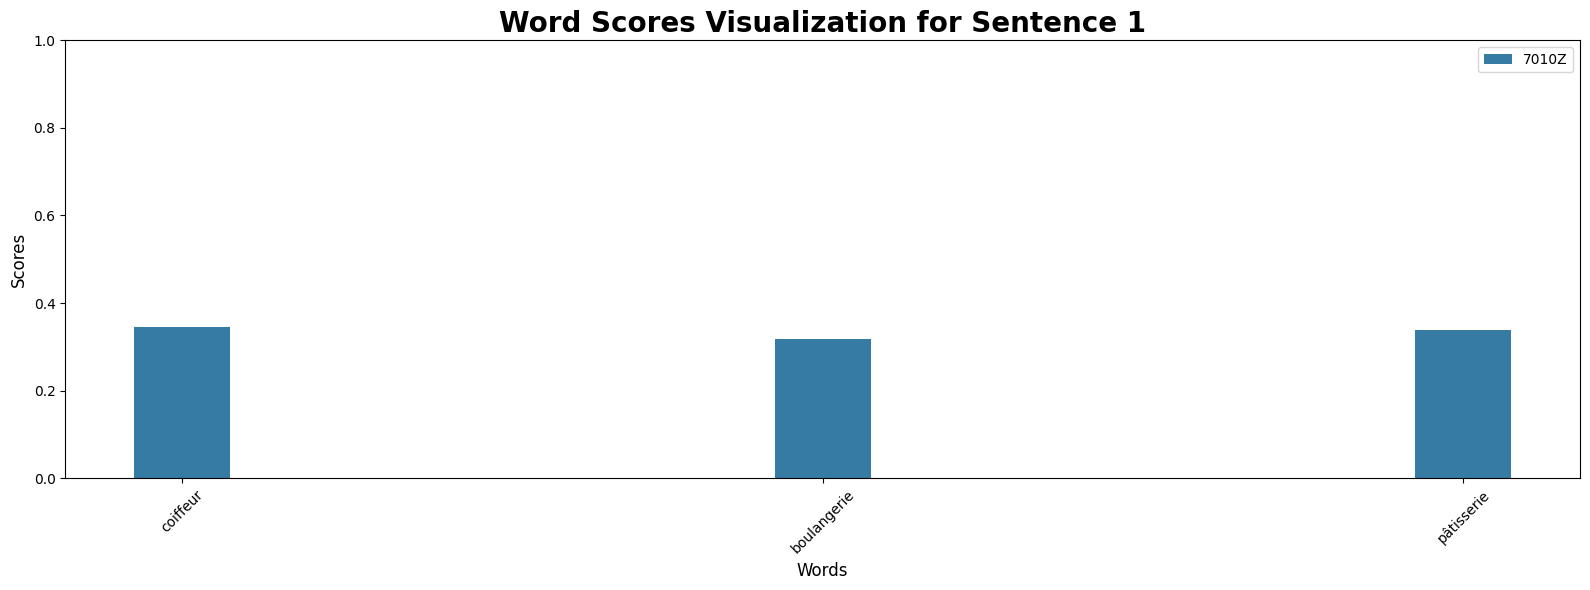

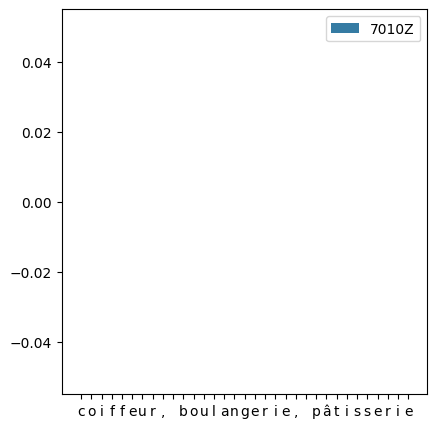

In [29]:
from torchFastText.explainability.visualisation import (
    visualize_letter_scores,
    visualize_word_scores,
)

pred, conf, all_scores, all_scores_letters = model.predict_and_explain(X)
visualize_word_scores(all_scores, text, pred_naf.reshape(1, -1))
visualize_letter_scores(all_scores_letters, text, pred_naf.reshape(1, -1))